# Decision tree

## Table of contents

### [1. Libraries import and Data preparation](#1)

### [2. Decision tree](#2)
#### [2.1 First iteration](#2.1)
#### [2.2 Second iteration](#2.2)


## 1. Libraries import and Data preparation
<div id='1'></div>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import graphviz
from sklearn import datasets
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.pyplot import figure
from supertree import SuperTree


##to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Creating paths to the data folder of the project and to the folder for saving the charts
path_data = r"C:\Users\dacol\Documents\Data Project - careerfoundry\ClimateWins_ML\02 Data"

# Importing the unscaled dataframe
df_weather = pd.read_csv(os.path.join(path_data,'Original Data','Dataset-weather-prediction-dataset-processed.csv'), sep =',')

# Importing the rated dataframe for pleasant days
df_rate = pd.read_csv(os.path.join(path_data,'Original Data','Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'), sep =',')

In [4]:
print(df_weather.shape)
print(df_rate.shape)

(22950, 170)
(22950, 16)


In [5]:
df_rate.describe()

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
count,2.295000e+04,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.0,22950.000000,22950.000000
mean,1.990984e+07,0.246797,0.348235,0.323791,0.194292,0.214989,0.216078,0.164444,0.277821,0.207669,0.446492,0.207712,0.155948,0.0,0.169673,0.051155
std,1.813833e+05,0.431157,0.476421,0.467931,0.395663,0.410824,0.411577,0.370686,0.447935,0.405647,0.497140,0.405679,0.362814,0.0,0.375354,0.220318
min,1.960010e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1.975092e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,1.991060e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2.007021e+07,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,2.022103e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


**NOTE** : Sonnblick station only has 0 (unpleasant) days : either the data is incomplete, either it is never a good day in this high place of Austria.

In [7]:
#isolating the columns names from the rate df since some weather stations are missing
rate_columns = df_rate.columns.to_list()

In [8]:
#isolating the weather columns to check for the stations to trim
weather_columns = df_weather.columns.to_list()

In [9]:
#splitting the column names to isolate the stations names
answer_stations = [col.split('_')[0] for col in rate_columns if '_' in col ]

In [10]:
#keeping only the weather stations maatching the stations from the rates
weather_stations = [col for col in weather_columns if col.split('_')[0] in answer_stations]

In [11]:
#creating a new df with the desired columns
df_weather_new = df_weather[weather_stations]
df_weather_new.head()

,BASEL_cloud_cover,BASEL_wind_speed,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_snow_depth,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_snow_depth,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,2.1,0.85,1.018,0.32,0.09,0,0.7,6.5,0.8,...,5,0.88,1.0003,0.45,0.34,0,4.7,8.5,6.0,10.9
1,6,2.1,0.84,1.018,0.36,1.05,0,1.1,6.1,3.3,...,7,0.91,1.0007,0.25,0.84,0,0.7,8.9,5.6,12.1
2,8,2.1,0.90,1.018,0.18,0.30,0,0.0,8.5,5.1,...,7,0.91,1.0096,0.17,0.08,0,0.1,10.5,8.1,12.9
3,3,2.1,0.92,1.018,0.58,0.00,0,4.1,6.3,3.8,...,7,0.86,1.0184,0.13,0.98,0,0.0,7.4,7.3,10.6
4,6,2.1,0.95,1.018,0.65,0.14,0,5.4,3.0,-0.7,...,3,0.80,1.0328,0.46,0.00,0,5.7,5.7,3.0,8.4


In [20]:
#Preparing weather df with only the temperatures (exclusion of dates and stations of ROMA, TOURS & GDANSK) as X

X = df_weather_new

X.shape

(22950, 147)

In [22]:
#Preparing rating df with only the stations' daily rates (exclusion of dates)as y

In [24]:
y = df_rate.drop(['DATE'], axis=1)

y.shape

(22950, 15)

## 2. Decision tree
<div id='2'></div>

### 2.1 First iteration
<div id='2.1'></div>

In [17]:
#Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16065, 147)
(6885, 147)
(16065, 15)
(6885, 15)


[Text(0.3673965146240182, 0.9827586206896551, 'x[49] <= 17.95\ngini = 0.316\nsamples = 16065\nvalue = [[12102, 3963]\n[10432, 5633]\n[10838, 5227]\n[12921, 3144]\n[12607, 3458]\n[12536, 3529]\n[13411, 2654]\n[11546, 4519]\n[12719, 3346]\n[8912, 7153]\n[12721, 3344]\n[13521, 2544]\n[16065, 0]\n[13342, 2723]\n[15232, 833]]'),
 Text(0.06394583232721614, 0.9482758620689655, 'x[98] <= 17.95\ngini = 0.1\nsamples = 10062\nvalue = [[9432.0, 630.0]\n[8442.0, 1620.0]\n[8865.0, 1197.0]\n[9976.0, 86.0]\n[10062.0, 0.0]\n[9466.0, 596.0]\n[9987.0, 75.0]\n[9143.0, 919.0]\n[9997.0, 65.0]\n[7492.0, 2570.0]\n[9669.0, 393.0]\n[9807.0, 255.0]\n[10062.0, 0.0]\n[9829.0, 233.0]\n[9917.0, 145.0]]'),
 Text(0.21567117347561715, 0.9655172413793103, 'True  '),
 Text(0.018039010517278384, 0.9137931034482759, 'x[19] <= 17.95\ngini = 0.029\nsamples = 7050\nvalue = [[6933.0, 117.0]\n[6408.0, 642.0]\n[6714.0, 336.0]\n[7037.0, 13.0]\n[7050.0, 0.0]\n[7014.0, 36.0]\n[7031.0, 19.0]\n[6842.0, 208.0]\n[7028.0, 22.0]\n[7050.0

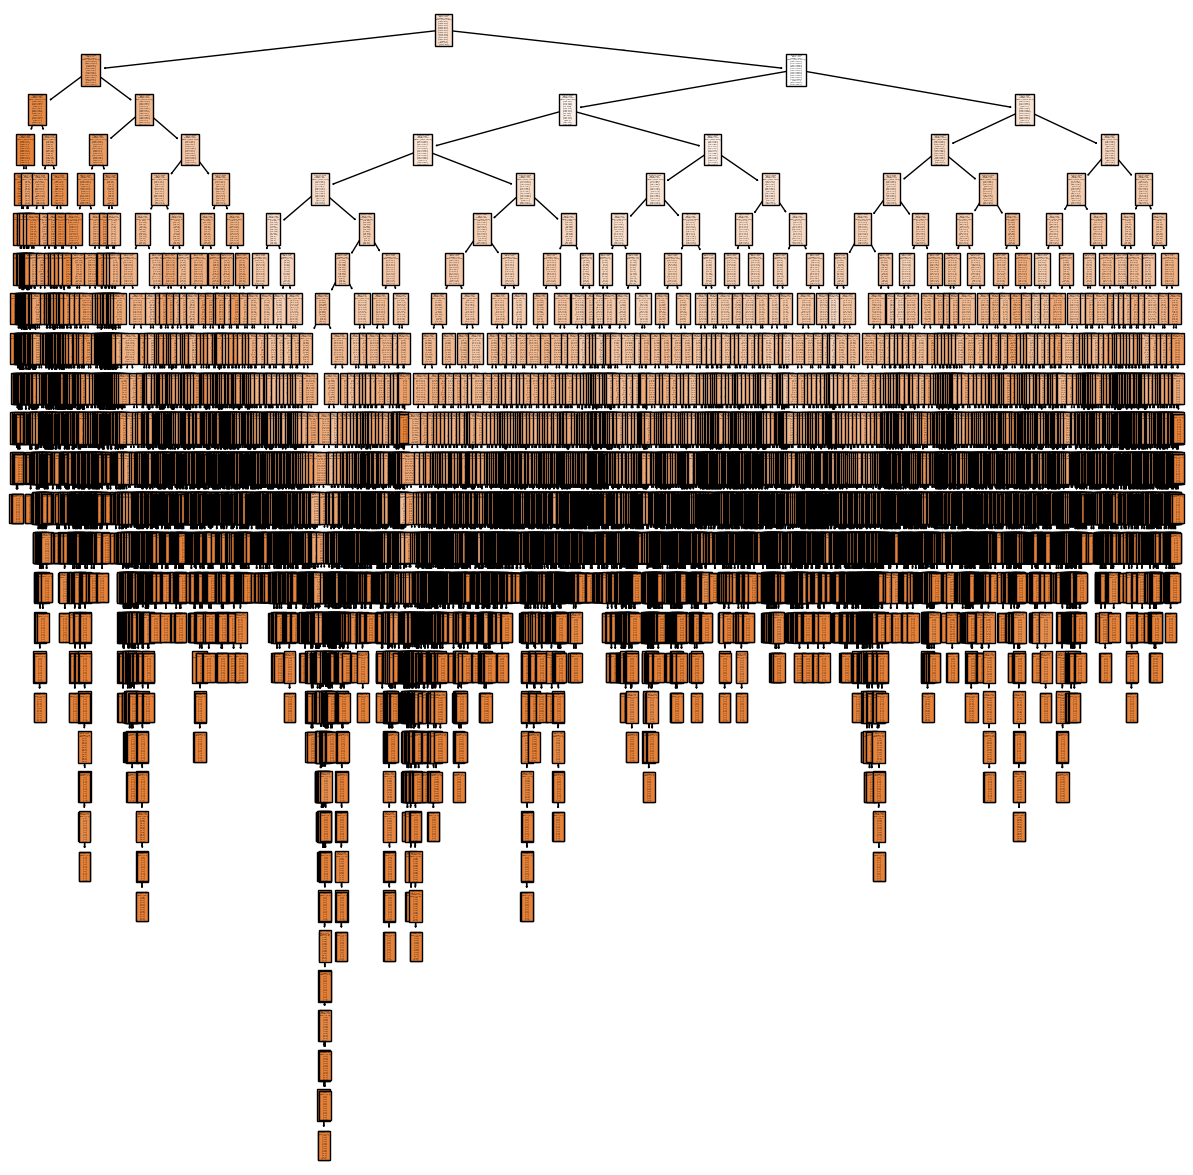

In [19]:
#Run Decision Tree classifier
pleasant_dt = DecisionTreeClassifier(criterion='gini', min_samples_split=2)
pleasant_dt.fit(X_train, y_train)
figure(figsize=(15,15))
tree.plot_tree(pleasant_dt, filled =True)

In [20]:
#creating an interactive tree to check multiple depths
super_tree = SuperTree(pleasant_dt)

# saving tree to html
super_tree.save_html()

HTML saved to output.html


In [21]:
#What is the training accuracy score? Using the cross validation method
y_pred_train = pleasant_dt.predict(X_train)
print('Train accuracy score: ',cross_val_score(pleasant_dt, X_train, y_train, cv = 3, scoring='accuracy').mean())


Train accuracy score:  0.6004979769685651


In [27]:
locations = list({x.split("_")[0] for x in df_rate.columns if x not in ["MONTH", "DATE"]})
locations.sort()
locations

['BASEL',
 'BELGRADE',
 'BUDAPEST',
 'DEBILT',
 'DUSSELDORF',
 'HEATHROW',
 'KASSEL',
 'LJUBLJANA',
 'MAASTRICHT',
 'MADRID',
 'MUNCHENB',
 'OSLO',
 'SONNBLICK',
 'STOCKHOLM',
 'VALENTIA']

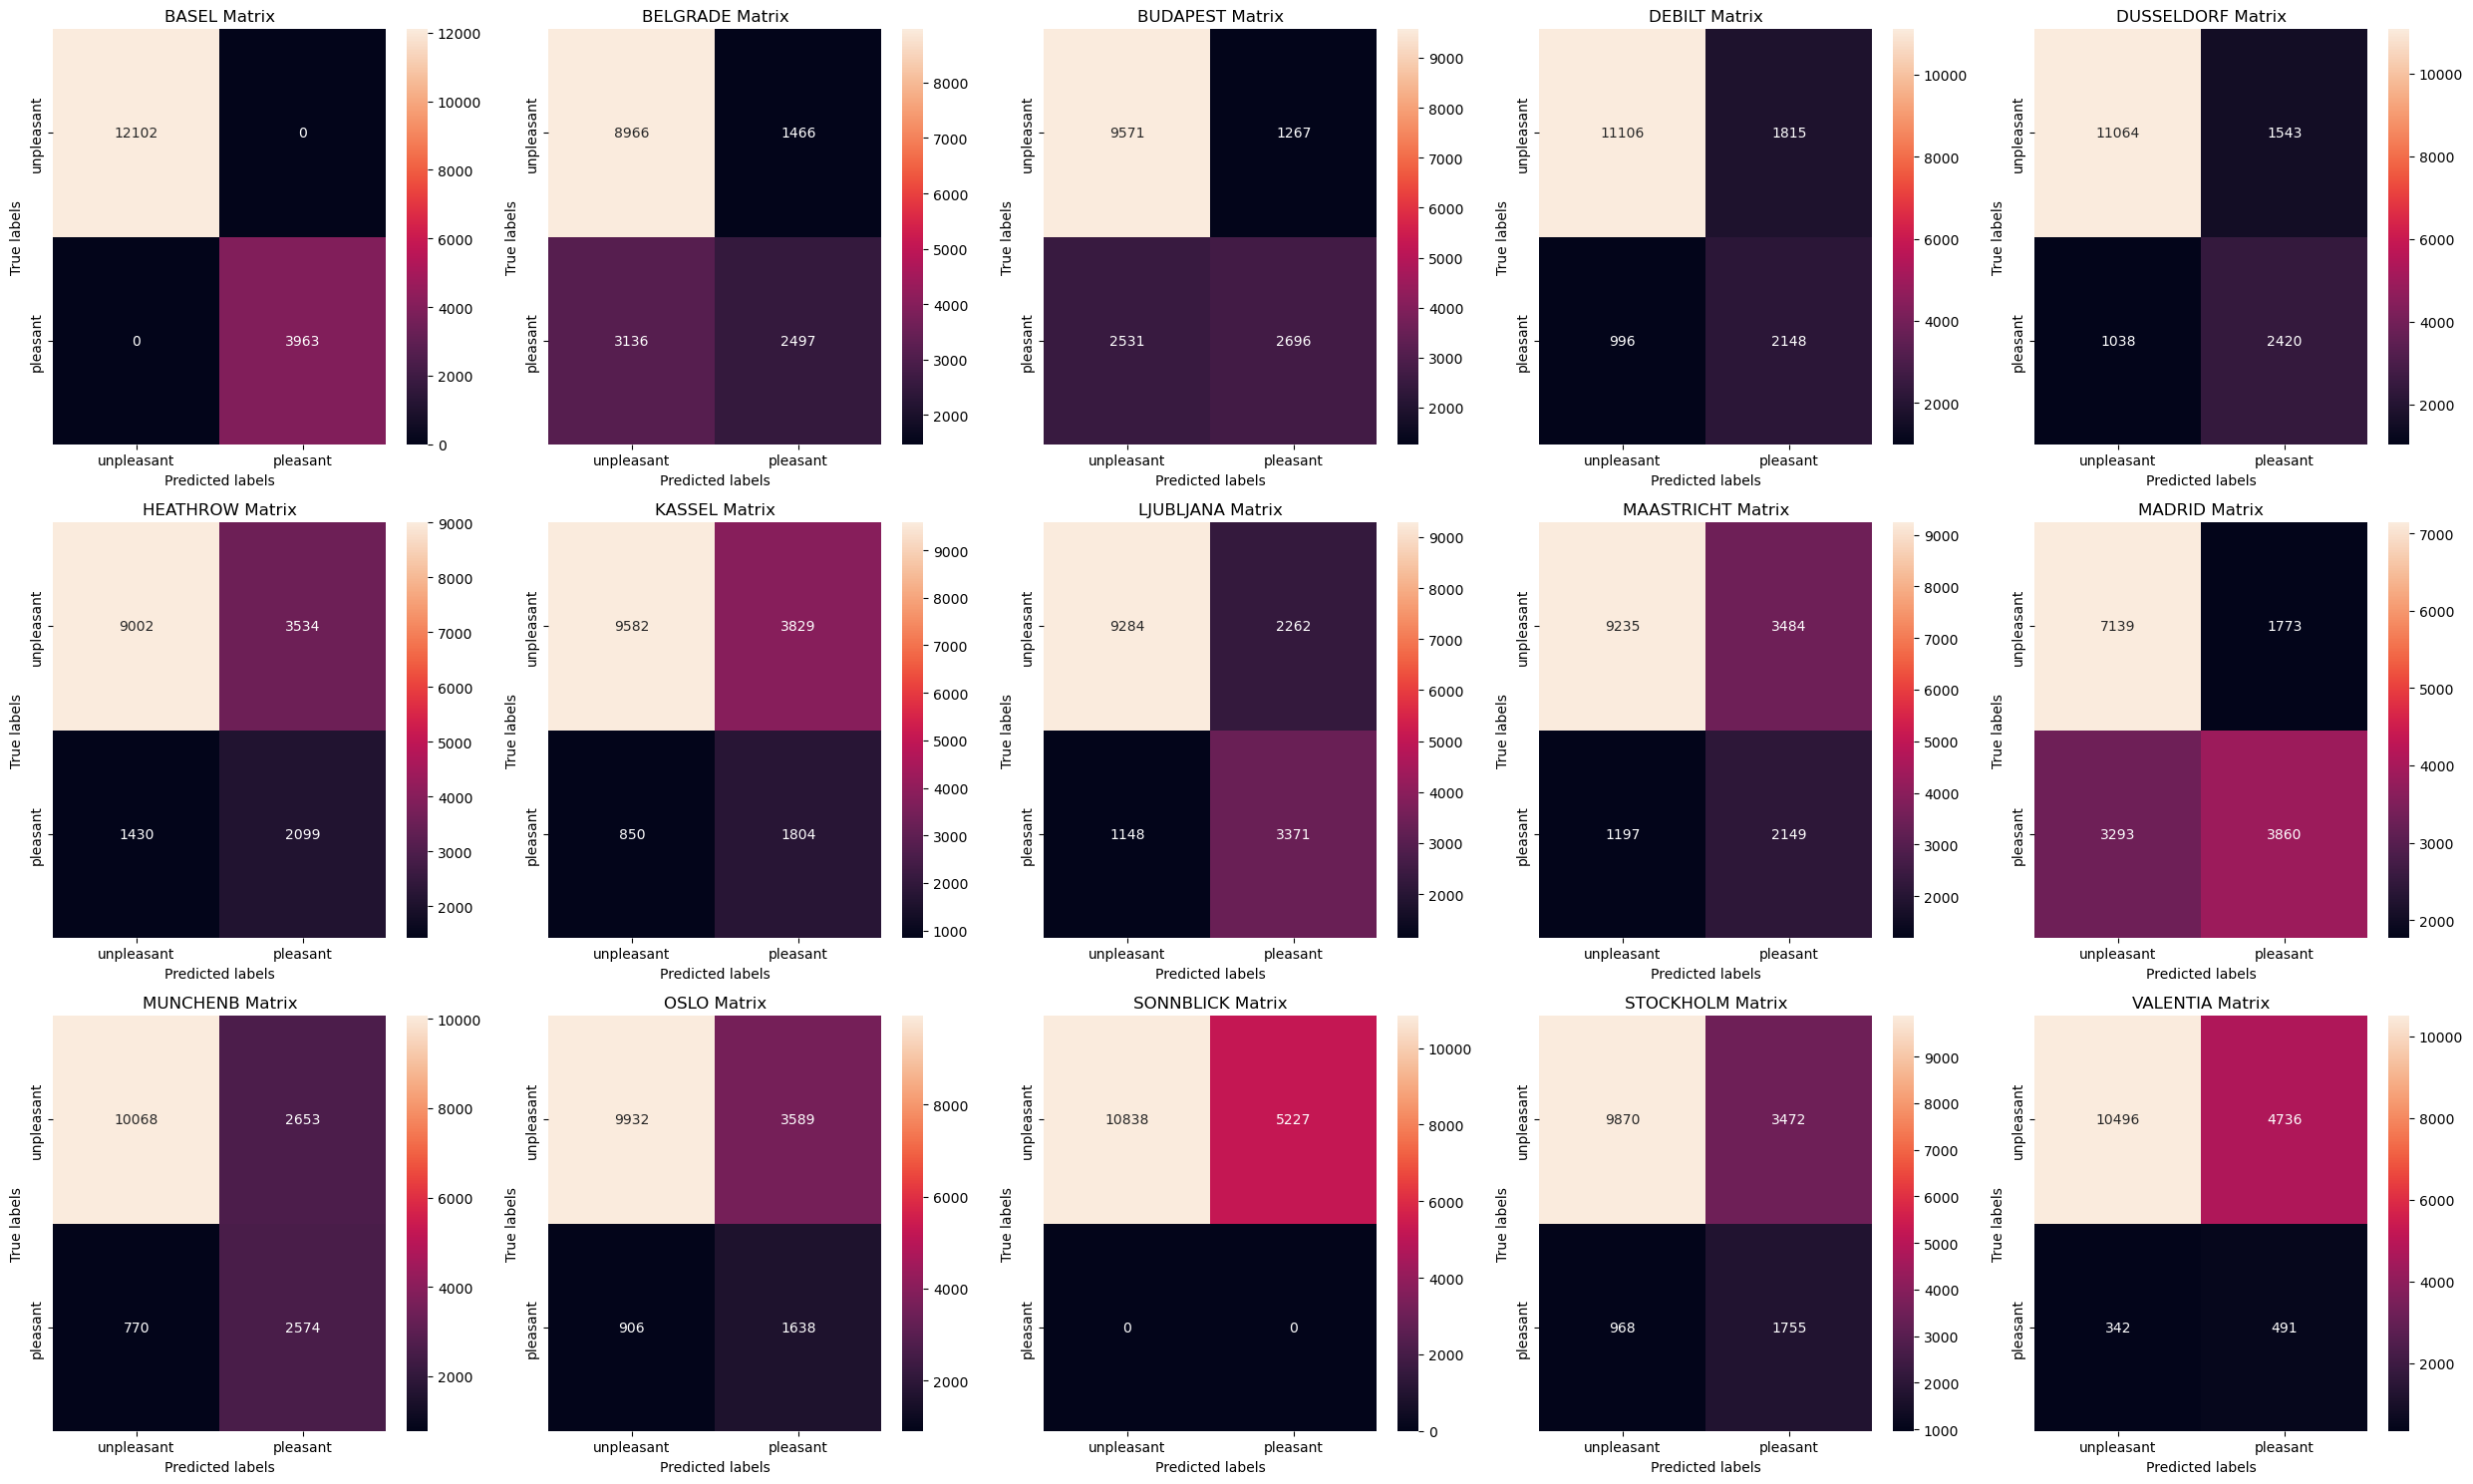

In [23]:
#Confusion matrix on the train data
key = "_pleasant_weather"
stations = []
figure, ax = plt.subplots(3, 5, figsize=(25,15))
labels = ['unpleasant', 'pleasant']   
count=0
for i in range(3):
    for j in range(5):
        name = locations[count]
        cm = confusion_matrix(y_train.loc[:,name+key], y_pred_train[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        ax[i,j] = sns.heatmap(cm, annot=True, fmt='g', ax=ax[i,j]);
        # labels, title and ticks
        ax[i,j].set_xlabel('Predicted labels');
        ax[i,j].set_ylabel('True labels'); 
        ax[i,j].set_title(name +' Matrix'); 
        ax[i,j].xaxis.set_ticklabels(labels);
        ax[i,j].yaxis.set_ticklabels(labels);
        count+=1

plt.tight_layout()

In [24]:
#What is the testing accuracy score? Using the cross validation method
y_pred_test = pleasant_dt.predict(X_test)
print('Test accuracy score: ',cross_val_score(pleasant_dt, X_test, y_test, cv = 3, scoring='accuracy').mean())

Test accuracy score:  0.557443718228032


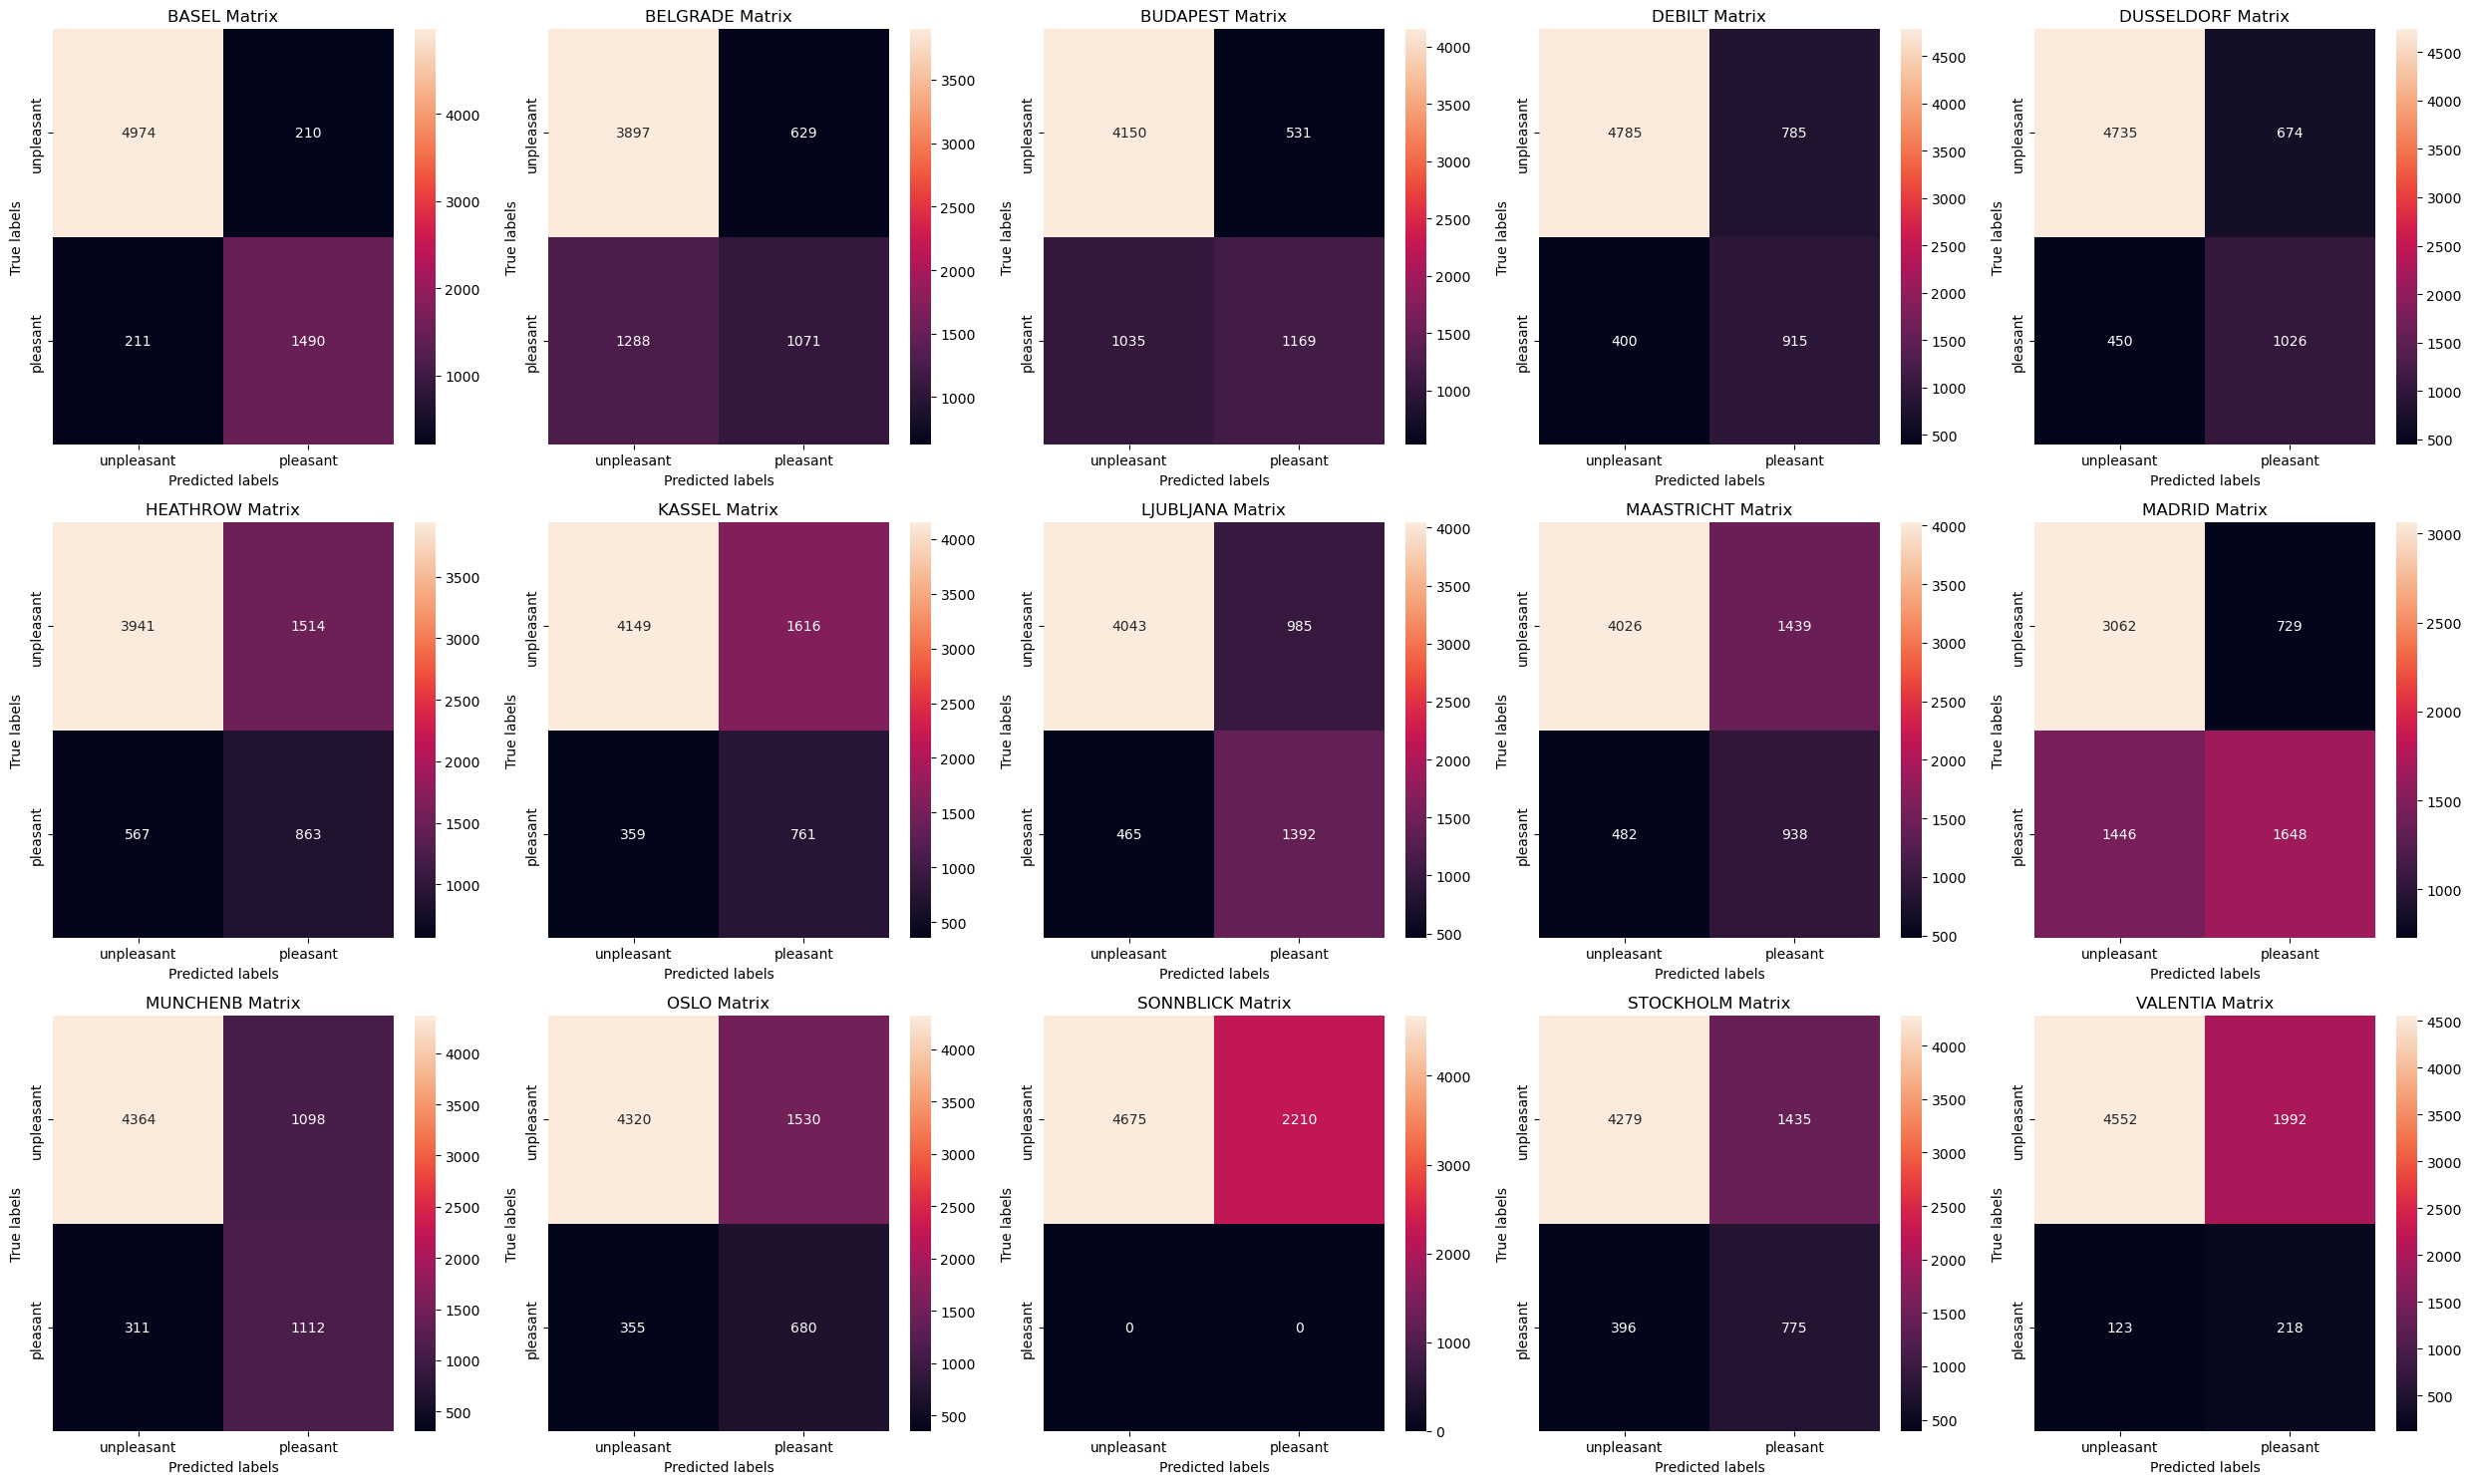

In [25]:
#Confusion matrix on the test data
key = "_pleasant_weather"
stations = []
figure, ax = plt.subplots(3, 5, figsize=(25,15))
labels = ['unpleasant', 'pleasant']     
count=0
for i in range(3):
    for j in range(5):
        name = locations[count]
        cm = confusion_matrix(y_test.loc[:,name+key], y_pred_test[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        ax[i,j] = sns.heatmap(cm, annot=True, fmt='g', ax=ax[i,j]);
        # labels, title and ticks
        ax[i,j].set_xlabel('Predicted labels');
        ax[i,j].set_ylabel('True labels'); 
        ax[i,j].set_title(name +' Matrix');
        ax[i,j].xaxis.set_ticklabels(labels);
        ax[i,j].yaxis.set_ticklabels(labels);
        count+=1

plt.tight_layout()

## 2.1 Second iteration
<div id='2.2'></div>

This new iteration will distinguish each station, making a decision tree for all weather inputs from each station, linked to its own daily pleasant or unpleasant tag.

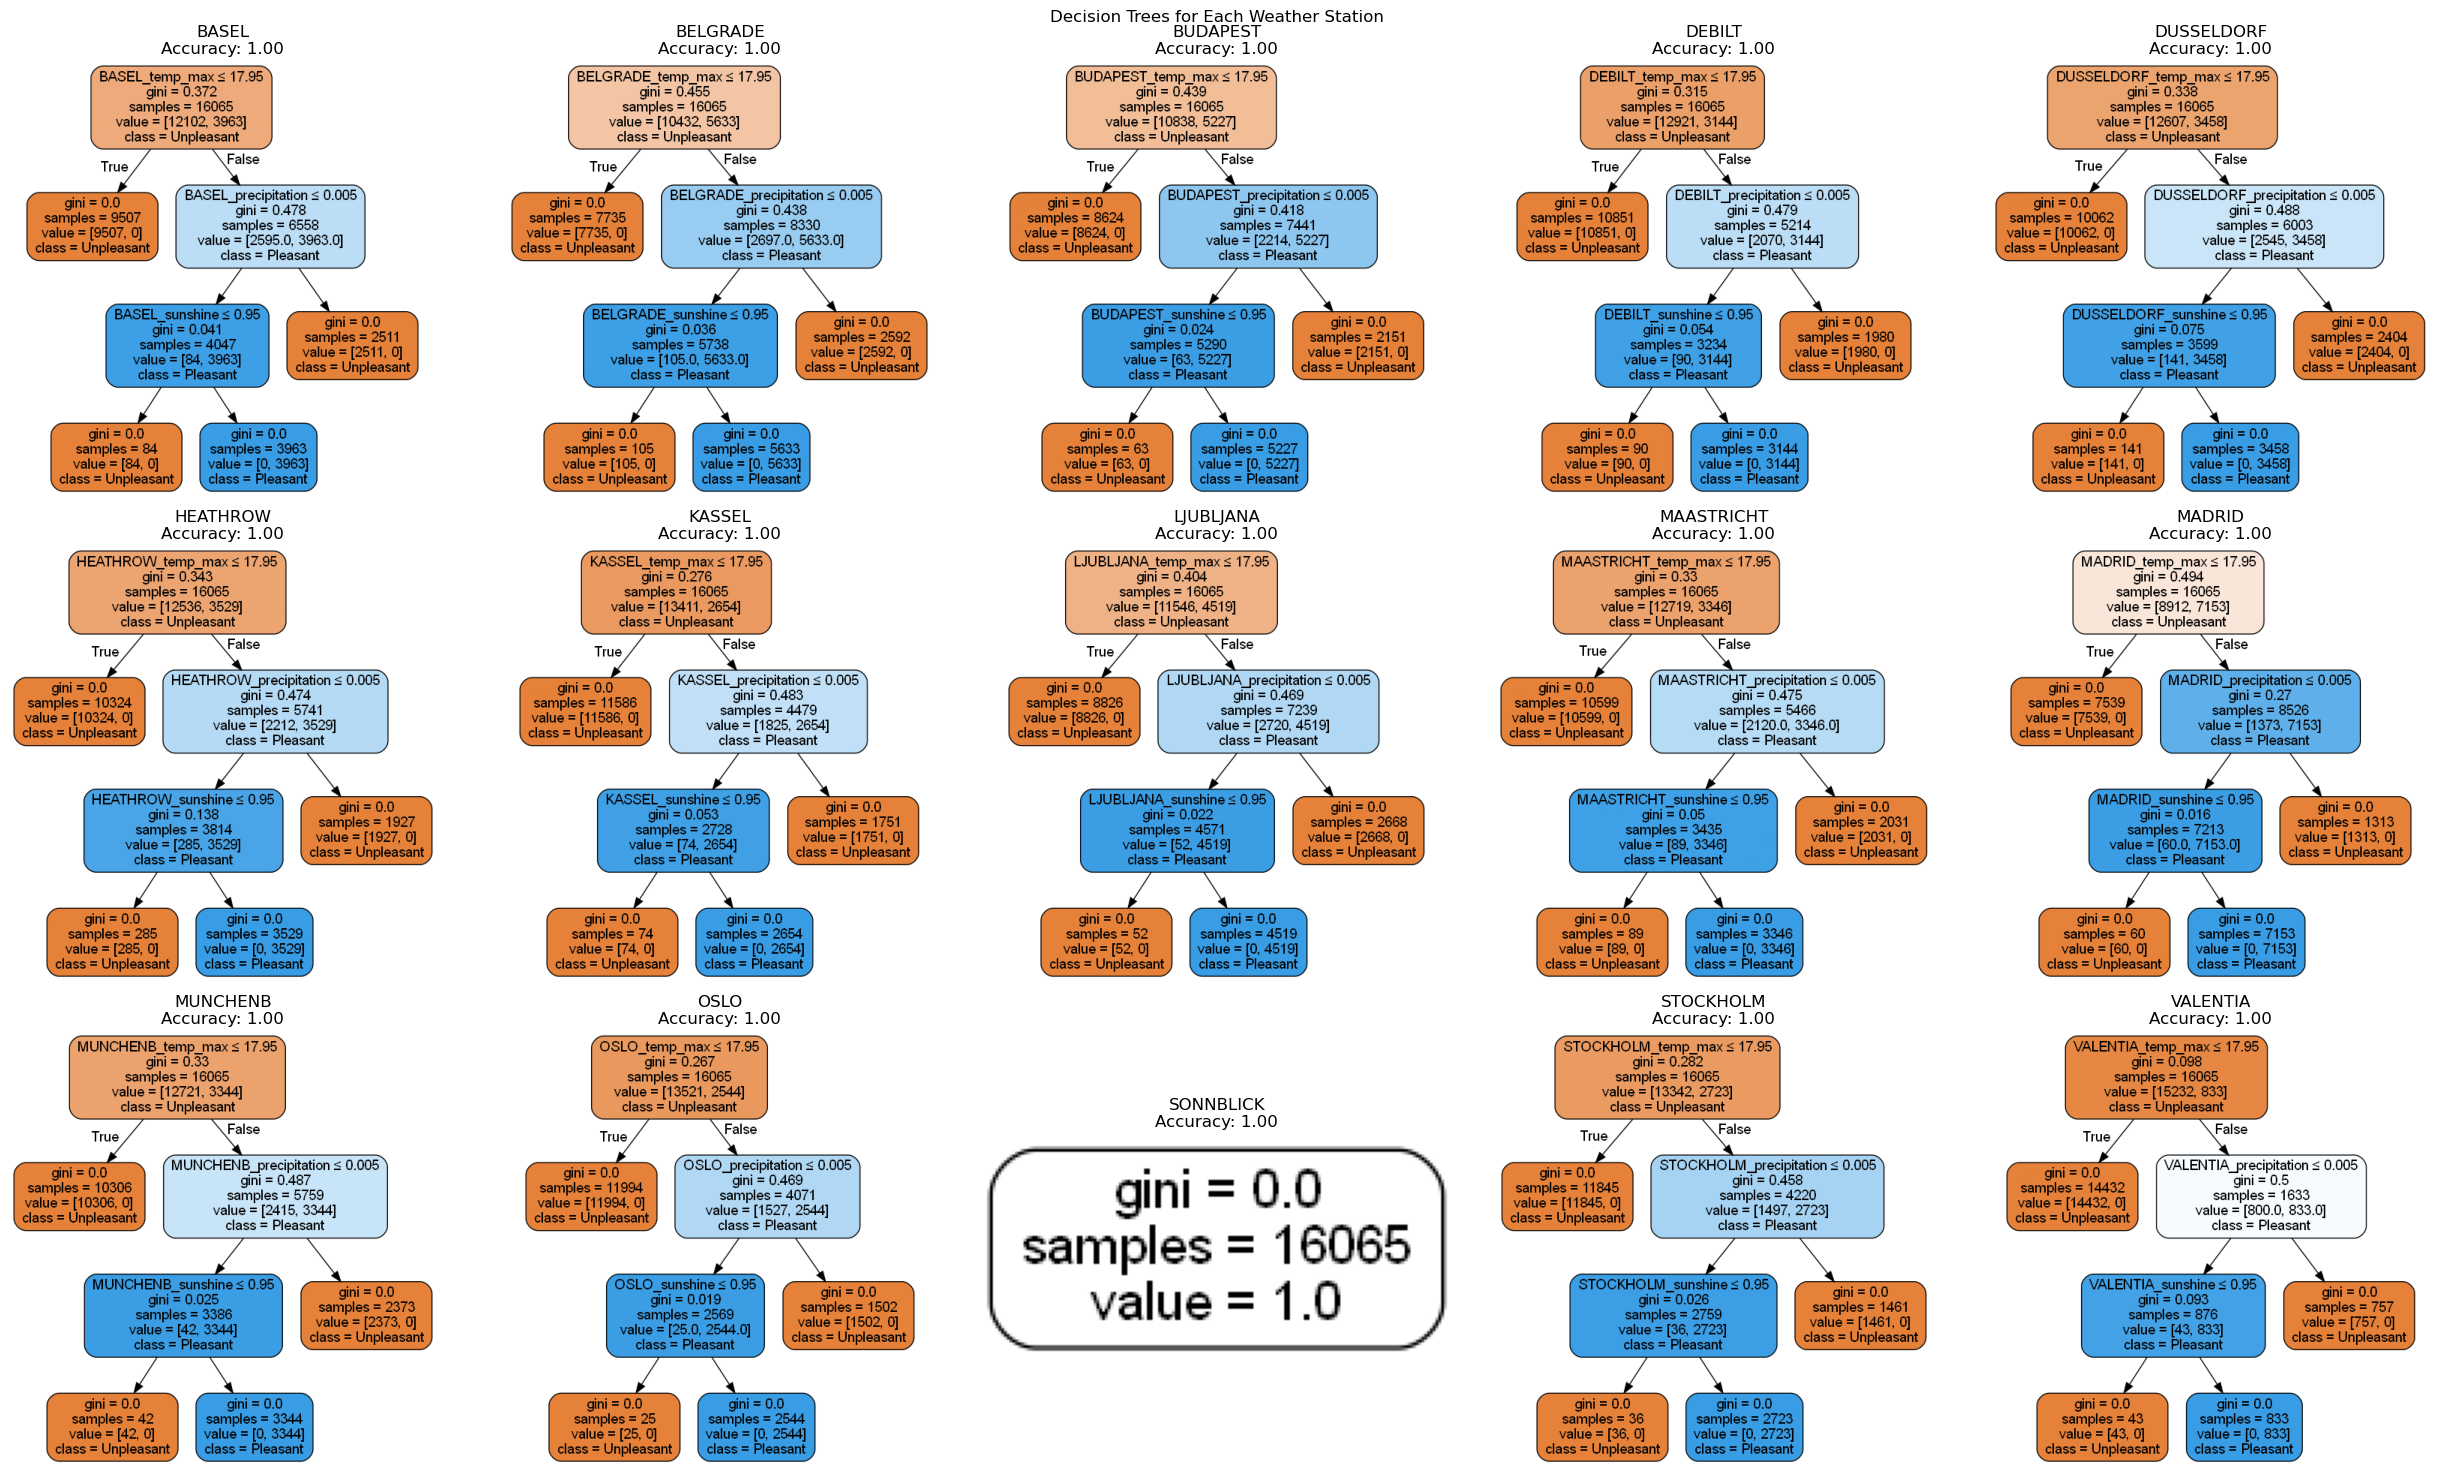

In [75]:
# List of weather stations
stations = locations

# Initialize dictionaries to store models and scores
models = {}
scores = {}

# Train and visualize decision trees for each station
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
fig.suptitle('Decision Trees for Each Weather Station')

for i, station in enumerate(stations):
    # Prepare the data for the station
    X_station = X[[col for col in X.columns if col.startswith(station)]]
    y_station = y[station + '_pleasant_weather']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_station, y_station, test_size=0.3, random_state=42)
    
    # Create and train the decision tree model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    # Predict the labels
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    score = accuracy_score(y_test, y_pred)
    scores[station] = score
    
    # Export the decision tree to DOT format
    dot_data = export_graphviz(model, out_file=None, 
                               feature_names=X_station.columns,  
                               class_names=['Unpleasant', 'Pleasant'],  
                               filled=True, rounded=True,  
                               special_characters=True)  
    graph = graphviz.Source(dot_data)  
    
    # Render the decision tree as a PNG image
    graph.render(filename=f"tree_{station}", format='png')
    img = plt.imread(f"tree_{station}.png")
    
    # Display the decision tree in the subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{station}\nAccuracy: {score:.2f}')

plt.tight_layout()
plt.show()


In [71]:
# Print accuracy scores for each station
for station, score in scores.items():
    print(f'{station}: Accuracy = {score:.4f}')

BASEL: Accuracy = 1.0000
BELGRADE: Accuracy = 1.0000
BUDAPEST: Accuracy = 1.0000
DEBILT: Accuracy = 1.0000
DUSSELDORF: Accuracy = 1.0000
HEATHROW: Accuracy = 1.0000
KASSEL: Accuracy = 1.0000
LJUBLJANA: Accuracy = 1.0000
MAASTRICHT: Accuracy = 1.0000
MADRID: Accuracy = 1.0000
MUNCHENB: Accuracy = 1.0000
OSLO: Accuracy = 1.0000
SONNBLICK: Accuracy = 1.0000
STOCKHOLM: Accuracy = 1.0000
VALENTIA: Accuracy = 1.0000


Perfect convergence !!!